In [1]:
from groq import Groq
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import google.generativeai as genai
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.util import ngrams
import re
from collections import Counter
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

c:\Users\jiyon\Desktop\Programming_projects\UNSW\LLM-reviewtransformation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")
plt.rcParams['axes.facecolor'] = '#d9dee2'    # Plot area background
plt.rcParams['figure.facecolor'] = '#d9dee2'  # Outside plot area (whole figure)

In [3]:
env_path = Path("../../.env")
load_dotenv(dotenv_path=env_path)  # set env for apis

True

In [4]:
df = pd.read_csv("./twitter_processed.csv")

FileNotFoundError: [Errno 2] No such file or directory: './twitter_processed.csv'

In [ ]:
df

,user,tweets,labels,follows,cleaned,cleaned_transform,bigram,trigram
0,user1,"b""@theresa_may U are a complete bitch an a sel...",1,following1,u complete bitch sell part deal dont u underst...,u are a complete bitch an a sell out what part...,"[('u', 'complete'), ('complete', 'bitch'), ('b...","[('u', 'complete', 'bitch'), ('complete', 'bit..."
1,user1,"b'RT @NadineDorries: So, it\xe2\x80\x99s true....",4,following1,true barnier eu pushing u deal leaver want eu ...,so it true barnier and eu pushing us to no dea...,"[('true', 'barnier'), ('barnier', 'eu'), ('eu'...","[('true', 'barnier', 'eu'), ('barnier', 'eu', ..."
2,user1,"b""@theresa_may @10DowningStreet Why do u never...",4,following1,u never celebrate st george day didnt u cover ...,why do u never celebrate st georges day an why...,"[('u', 'never'), ('never', 'celebrate'), ('cel...","[('u', 'never', 'celebrate'), ('never', 'celeb..."
3,user1,"b""@Anna_Soubry @theresa_may @sarahwollaston @B...",1,following1,fuck bit leave dont u understand,fuck off what bit about leave dont u understand,"[('fuck', 'bit'), ('bit', 'leave'), ('leave', ...","[('fuck', 'bit', 'leave'), ('bit', 'leave', 'd..."
4,user1,b'RT @RealitySmash: The left want this video o...,0,following1,left want video muslim peaceful muslimming she...,the left want this video of muslims doing some...,"[('left', 'want'), ('want', 'video'), ('video'...","[('left', 'want', 'video'), ('want', 'video', ..."
...,...,...,...,...,...,...,...,...
4215,user52,And she's pushing for Sharia Law in America. ...,0,following65,shes pushing sharia law america shes dangerous,and shes pushing for sharia law in america she...,"[('shes', 'pushing'), ('pushing', 'sharia'), (...","[('shes', 'pushing', 'sharia'), ('pushing', 's..."
4216,user52,RT @RGodGivenRights: @Lrihendry @PinkBelgium @...,0,following65,people cant allow illegals rewrite law sharia ...,we the people cant allow illegals rewrite our ...,"[('people', 'cant'), ('cant', 'allow'), ('allo...","[('people', 'cant', 'allow'), ('cant', 'allow'..."
4217,user52,RT @monk_asian: #Sharia's procedure of #hand a...,0,following65,sharia procedure hand foot chopping tie reduce...,sharias procedure of hand and foot chopping th...,"[('sharia', 'procedure'), ('procedure', 'hand'...","[('sharia', 'procedure', 'hand'), ('procedure'..."
4218,user52,RT @LanceSilver1: #Sharia Law VIOLATES Our #Bi...,0,following65,sharia law violates billofrights 1440 yr clash...,sharia law violates our billofrights 1440 yr c...,"[('sharia', 'law'), ('law', 'violates'), ('vio...","[('sharia', 'law', 'violates'), ('law', 'viola..."


In [ ]:
df = df.drop_duplicates(subset=["tweets"])

# Groq

In [20]:
client = Groq(api_key=os.environ["GROQ_API_KEY"])
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [21]:
model = genai.GenerativeModel('gemini-1.5-flash')

In [ ]:
def transform_tweet_with_groq(tweet): # set up api
    prompt = f"""
 

    "{tweet}"
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-8b-8192",
    )
    response_text = chat_completion.choices[0].message.content.strip("```")
    return response_text

In [23]:
from google.api_core.retry import Retry 

retry_policy = Retry(
    initial=1.0,  
    maximum=10.0, 
    multiplier=2.0, 
    deadline=30.0,  
) # retry for error

In [27]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold, RequestOptions
def transform_tweet(review): # transformation function
    prompt = f"""
    Transform the abusive tweet into non abusive one i.e. into a more polite and respectful tweet while maintaining the overall meaning and context as much as possible.
    Only return the transformed tweet. Do not write anything apart from the transformed tweet.
    Below is the tweet:
    
    {review}
    """
    try:
        response = retry_policy(model.generate_content)(
            prompt,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
            },
        )
        return response.text.strip()
    except Exception as e:
        print(f"Error occurred: {e}")
        return None  

In [ ]:
df = (
    df.groupby('labels', group_keys=False)  
    .apply(lambda x: x.sample(n=100, random_state=42))  # sample 100 tweets for each category
)

df = df[['tweets', 'cleaned', 'cleaned_transform', 'labels']]

df = df.reset_index(drop=True)
df['batch'] = df.index // 20   # set batch size   

C:\Users\jiyon\AppData\Local\Temp\ipykernel_1944\72928994.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=100, random_state=42))


In [25]:
# groq transformation
df['transformed_tweets_groq'] = df['cleaned_transform'].apply(lambda x: transform_tweet_with_groq(x))

In [26]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""If you take the time to do the math, you'll f...",1,"If you perform the calculations, you will find...",1,"""If you take the time to do the calculations, ..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims believe the Quran is a truthful s...,1,"""Some Muslims believe that the Quran is true b..."
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,That painting by Jim Carrey of Shari Headley i...,1,"""That painting by Jim Carrey captures a striki..."
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I believe Islamic laws and beliefs often clas...",1,I believe Islam is incompatible with British v...,1,"""I believe there should be a discussion about ..."
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""Concerned about PM Theresa May's response to ...",1,A YouTube comment I just read criticized There...,1,"""Theresa May seems to have strong alignment wi..."
...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""The 'outrage machine' is in high gear, it see...",1,The manufactured outrage is intense.,1,"""The intense reaction seems to be quite active..."
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's worrying to consider the potential conse...",1,It's concerning to imagine the consequences sh...,1,"""It's concerning to think about the consequenc..."
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling that the establishment seems re...",1,"And yet, those in power don't want this for Br...",1,"""It's interesting to consider why the establis..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling humbled and grateful for the supp...",1,I'm enjoying a lot of positive attention lately.,1,"""It's amazing to see how many people I am conn..."


In [28]:
df['transformed_tweets_gemini'] = None

In [29]:
# gemini transformation
index_to_transform = df[df['transformed_tweets_gemini'].isna()].index
for counter, idx in enumerate(index_to_transform):
    clean_review = df.loc[idx, 'cleaned_transform']
    improved_text = transform_tweet(clean_review)
    df.at[idx, 'transformed_tweets_gemini'] = improved_text
    time.sleep(2)
    print(f"{idx + 1}/{len(index_to_transform)}")


1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/500
139/

In [30]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b..."
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki..."
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ..."
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi..."
...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""The 'outrage machine' is in high gear, it see...",1,"Concerns are being amplified unnecessarily, it...",1,"""The intense reaction seems to be quite active..."
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's worrying to consider the potential conse...",1,The safety and well-being of the U.S. Presiden...,1,"""It's concerning to think about the consequenc..."
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling that the establishment seems re...",1,It's unclear why those in power oppose this fo...,1,"""It's interesting to consider why the establis..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling humbled and grateful for the supp...",1,I'm so grateful for the recent increase in sup...,1,"""It's amazing to see how many people I am conn..."


In [31]:
df.to_csv("../../Dataset/tweets/transformed_tweets.csv", index=False)

# GPT 4o

In [13]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.environ['GPT_API_KEY'])

def transform_tweet_with_gpt4o(tweet):
    prompt = f"""
    Transform the abusive tweet into non abusive one i.e. into a more polite and respectful tweet while maintaining the overall meaning and context as much as possible.
    Only return the transformed tweet. Do not write anything apart from the transformed tweet.
    Below is the tweet:

    "{tweet}"
    """
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[{
            "role": "user",
            "content": prompt.strip()
        }]
    )

    return completion.choices[0].message.content.strip()


In [14]:
df['transformed_tweets_gpt'] = df['cleaned_transform'].apply(lambda x: transform_tweet_with_gpt4o(x))

In [15]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o...",1,"If you perform the calculations, you will find...",1,"""If you take the time to do the calculations, ..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\r\n\r\n""I'm fas...",1,Some Muslims believe the Quran is a truthful s...,1,"""Some Muslims believe that the Quran is true b..."
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal...",1,That painting by Jim Carrey of Shari Headley i...,1,"""That painting by Jim Carrey captures a striki..."
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev...",1,I believe Islam is incompatible with British v...,1,"""I believe there should be a discussion about ..."
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ...",1,A YouTube comment I just read criticized There...,1,"""Theresa May seems to have strong alignment wi..."
...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac...",1,The manufactured outrage is intense.,1,"""The intense reaction seems to be quite active..."
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ...",1,It's concerning to imagine the consequences sh...,1,"""It's concerning to think about the consequenc..."
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista...",1,"And yet, those in power don't want this for Br...",1,"""It's interesting to consider why the establis..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised...",1,I'm enjoying a lot of positive attention lately.,1,"""It's amazing to see how many people I am conn..."


# Deepseek API

In [34]:
client = OpenAI(
    api_key=os.environ['DEEPSEEK_API_KEY'],
    base_url="https://api.deepseek.com"  
)

def transform_tweet_with_deepseek(tweet):
    prompt = f"""
    Transform the abusive tweet into a non-abusive one, i.e., into a more polite and respectful tweet while maintaining the overall meaning and context as much as possible.
    Only return the transformed tweet. Do not write anything apart from the transformed tweet.
    Below is the tweet:

    "{tweet}"
    """

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "user", "content": prompt.strip()}
        ],
        stream=False
    )

    return response.choices[0].message.content.strip()


In [35]:
df['transformed_tweets_deepseek'] = df['cleaned_transform'].apply(lambda x: transform_tweet_with_deepseek(x))

In [38]:
df['deepseek_transformed'] = None

In [46]:
df.to_csv("../../Dataset/tweets/transformed_tweets.csv", index=False)

# Manually label successful transformations

In [5]:
df = pd.read_csv("../../Dataset/tweets/transformed_tweets.csv")

In [6]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,gpt_transformed,transformed_tweets_deepseek,deepseek_transformed
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",1,"""If you take the time to analyze the data, it ...",1
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",1,"""Some Muslims believe the Quran is true becaus...",1
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",1,"""Jim Carrey's painting of Sharia Huckabee is a...",1
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",1,"""I believe Islam should not be practiced in th...",1
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",1,"""Theresa May seems to be very supportive of th...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""The 'outrage machine' is in high gear, it see...",1,"Concerns are being amplified unnecessarily, it...",1,"""The intense reaction seems to be quite active...",1,"""The level of outrage seems quite intense, don...",1
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's worrying to consider the potential conse...",1,The safety and well-being of the U.S. Presiden...,1,"""It's concerning to think about the consequenc...",1,"""It's concerning to think about the potential ...",1
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling that the establishment seems re...",1,It's unclear why those in power oppose this fo...,1,"""It's interesting to consider why the establis...",1,"""It makes you wonder whose side the establishm...",1
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling humbled and grateful for the supp...",1,I'm so grateful for the recent increase in sup...,1,"""It's amazing to see how many people I am conn...",1,"""I'm really grateful for all the support and k...",1


# Set up hateBert for hate analysis

In [7]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  

def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class





KeyboardInterrupt: 

In [50]:
df['before_hatebert_pred'] = df['cleaned_transform'].apply(predict_hate_speech)
df['after_hatebert_pred_groq'] = df['transformed_tweets_groq'].apply(predict_hate_speech)
df['after_hatebert_pred_gemini'] = df['transformed_tweets_gemini'].apply(predict_hate_speech)
df['after_hatebert_pred_gpt4o'] = df['transformed_tweets_gpt'].apply(predict_hate_speech)
df['after_hatebert_pred_deepseek'] = df['transformed_tweets_deepseek'].apply(predict_hate_speech)

In [51]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,gpt_transformed,transformed_tweets_deepseek,deepseek_transformed,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",1,"""If you take the time to analyze the data, it ...",1,1,1,1,1,1
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",1,"""Some Muslims believe the Quran is true becaus...",1,1,1,1,1,1
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",1,"""Jim Carrey's painting of Sharia Huckabee is a...",1,1,1,1,1,1
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",1,"""I believe Islam should not be practiced in th...",1,1,1,1,1,1
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",1,"""Theresa May seems to be very supportive of th...",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""The 'outrage machine' is in high gear, it see...",1,"Concerns are being amplified unnecessarily, it...",1,"""The intense reaction seems to be quite active...",1,"""The level of outrage seems quite intense, don...",1,1,1,1,1,1
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's worrying to consider the potential conse...",1,The safety and well-being of the U.S. Presiden...,1,"""It's concerning to think about the consequenc...",1,"""It's concerning to think about the potential ...",1,1,1,1,1,1
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling that the establishment seems re...",1,It's unclear why those in power oppose this fo...,1,"""It's interesting to consider why the establis...",1,"""It makes you wonder whose side the establishm...",1,1,1,1,1,1
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling humbled and grateful for the supp...",1,I'm so grateful for the recent increase in sup...,1,"""It's amazing to see how many people I am conn...",1,"""I'm really grateful for all the support and k...",1,1,1,1,1,1


In [53]:
df.to_csv("../../Dataset/tweets/hatebert_labeled.csv", index=False)

# SWAD dataset

In [4]:
swad = pd.read_csv('../../Dataset/tweets/SWAD v1.tsv', sep='\t')
swad2 = pd.read_csv('../../Dataset/tweets/SWAD v2.tsv', sep='\t')
swad = swad[['Tweets', 'Label']]
swad2 = swad2.iloc[:,1:]
swad2.columns = ['Tweets', 'Label']

swad = pd.concat([swad, swad2], ignore_index=True)

In [5]:
swad

,Tweets,Label
0,"@USER Someone should'veTaken"" this piece of <b...",No
1,@USER @USER Oh noes! Tough <b>shit</b>,Yes
2,@USER @USER @USER @USER LOL!!! Throwing the <b...,Yes
3,@USER @USER Da <b>fuck</b> is going on people?...,Yes
4,@USER <b>fuck</b> off,Yes
...,...,...
4083,<USER> being a white male is one <b>hell</b> o...,No
4084,<b>Bitch</b> I ain't crabby stop saying that!!,No
4085,You know you've done a good job at work when y...,No
4086,Man they are throwing the <b>shit</b> out of t...,No


In [6]:
stopwords_set = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"@USER", '', text)  
    text = re.sub(r"<USER>", '', text)  
    text = re.sub(r"<b>|</b>", '', text) 
    text = re.sub(r'\\x[a-fA-F0-9]{2}', '', text)  
    text = re.sub(r'http\S+|www\S+', '', text)  
    text = re.sub(r'#', '', text)  
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()  
    text = text.lower()  
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_set]
    return ' '.join(filtered_tokens)

def get_word_frequencies(tweets):
    all_tokens = []
    for tweet in tweets:
        all_tokens.extend(clean_text(tweet).split())  
    return dict(Counter(all_tokens).most_common(50))


In [7]:
swad['cleaned_text'] = swad['Tweets'].apply(clean_text)

In [8]:
swad

,Tweets,Label,cleaned_text
0,"@USER Someone should'veTaken"" this piece of <b...",No,someone shouldvetaken piece shit volcano
1,@USER @USER Oh noes! Tough <b>shit</b>,Yes,oh no tough shit
2,@USER @USER @USER @USER LOL!!! Throwing the <b...,Yes,lol throwing bullshit flag nonsense putuporshu...
3,@USER @USER Da <b>fuck</b> is going on people?...,Yes,da fuck going people there men room womens roo...
4,@USER <b>fuck</b> off,Yes,fuck
...,...,...,...
4083,<USER> being a white male is one <b>hell</b> o...,No,white male one hell drug
4084,<b>Bitch</b> I ain't crabby stop saying that!!,No,bitch aint crabby stop saying
4085,You know you've done a good job at work when y...,No,know youve done good job work scare someone ba...
4086,Man they are throwing the <b>shit</b> out of t...,No,man throwing shit tape


In [9]:
abusive = swad[swad['Label'] == "Yes"]['cleaned_text'].tolist()

get_word_frequencies(abusive).keys()

dict_keys(['shit', 'fuck', 'bitch', 'dont', 'like', 'url', 'fucking', 'bullshit', 'people', 'get', 'know', 'u', 'gun', 'one', 'liberal', 'think', 'go', 'im', 'even', 'youre', 'antifa', 'hell', 'thats', 'control', 'cant', 'time', 'say', 'dick', 'right', 'pussy', 'asshole', 'back', 'trump', 'amp', 'damn', 'good', 'piece', 'want', 'thing', 'would', 'better', 'see', 'woman', 'conservative', 'stop', 'saying', 'never', 'oh', 'need', 'way'])

# Dynamically-Generated-Hate-Speech-Dataset (Abuse)

In [10]:
abuse = pd.read_csv("../../Dataset/tweets/hatespeech_data.csv")
abuse = abuse[['tweet', 'class']] # 0 hate speech, 1 offensive langauge 2 neither

In [11]:
stopwords_set = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def clean_text_abuse(text, ngram=True):
    text = re.sub(r"b['\"]", '', text)
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\\\w+', '', text)
    text = re.sub(r'\\x[a-fA-F0-9]{2}', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.split(r'\btruncated\b', text, maxsplit=1)[0]
    text = re.sub(r'#', '', text)
    text = re.sub(r'&.*', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower()  

    tokens = word_tokenize(text)
    if ngram:
        filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_set]
        text = ' '.join(filtered_tokens)

    return text
def get_word_frequencies(tweets):
    all_tokens = []
    for tweet in tweets:
        all_tokens.extend(clean_text_abuse(tweet).split())  
    return dict(Counter(all_tokens).most_common(20))

In [12]:
abuse['cleaned_tweet'] = abuse['tweet'].apply(clean_text_abuse)

In [13]:
# subset to hate speech and offensive language
abuse_01 = abuse[(abuse['class'] == 1)| (abuse['class'] == 0)]['cleaned_tweet'].tolist()
abuse_01_counts = get_word_frequencies(abuse_01)

In [14]:
# subset to neither
abuse_2 = abuse[abuse['class'] == 2]['cleaned_tweet'].tolist()
abuse_2_counts = get_word_frequencies(abuse_2)

In [15]:
# logic here is to get the ratio between words that are hateful compared to neutral, and get the highest occurence words of hateful/abuse compared to neutral
alpha = 0.01  # smoothing parameter

df_counts = pd.DataFrame([abuse_01_counts, abuse_2_counts]).fillna(0).T
df_counts.columns = ['abuse+hate', 'neutral']

df_counts['smoothed_hate'] = df_counts['abuse+hate'] + alpha
df_counts['smoothed_neutral'] = df_counts['neutral'] + alpha
df_counts['log_odds'] = np.log(df_counts['smoothed_hate'] / df_counts['smoothed_neutral'])
df_counts['var'] = (1 / df_counts['smoothed_hate']) + (1 / df_counts['smoothed_neutral'])
df_counts['std_error'] = np.sqrt(df_counts['var'])
df_counts['z_score'] = df_counts['log_odds'] / df_counts['std_error']

keywords = df_counts.nlargest(15, 'z_score').index.tolist()

In [16]:
df_counts.nlargest(15, 'z_score')

,abuse+hate,neutral,smoothed_hate,smoothed_neutral,log_odds,var,std_error,z_score
like,2199.0,283.0,2199.01,283.01,2.050280,0.003988,0.063152,32.465724
im,1623.0,206.0,1623.01,206.01,2.064113,0.005470,0.073961,27.908018
dont,1414.0,156.0,1414.01,156.01,2.204265,0.007117,0.084363,26.128449
got,1264.0,114.0,1264.01,114.01,2.405758,0.009562,0.097787,24.602031
get,1208.0,166.0,1208.01,166.01,1.984682,0.006852,0.082774,23.977103
u,1138.0,138.0,1138.01,138.01,2.109710,0.008125,0.090136,23.405741
lol,793.0,132.0,793.01,132.01,1.792958,0.008836,0.094001,19.073805
bitch,10088.0,0.0,10088.01,0.01,13.824273,100.000099,10.000005,1.382427
hoe,3683.0,0.0,3683.01,0.01,12.816656,100.000272,10.000014,1.281664
pussy,1940.0,0.0,1940.01,0.01,12.175619,100.000515,10.000026,1.217559


In [17]:
df_counts.nsmallest(15, 'z_score')

,abuse+hate,neutral,smoothed_hate,smoothed_neutral,log_odds,var,std_error,z_score
trash,0.0,628.0,0.01,628.01,-11.047726,100.001592,10.000080,-1.104764
bird,0.0,436.0,0.01,436.01,-10.682835,100.002294,10.000115,-1.068271
yankee,0.0,262.0,0.01,262.01,-10.173553,100.003817,10.000191,-1.017336
charlie,0.0,244.0,0.01,244.01,-10.102379,100.004098,10.000205,-1.010217
yellow,0.0,196.0,0.01,196.01,-9.883336,100.005102,10.000255,-0.988308
one,0.0,134.0,0.01,134.01,-9.503085,100.007462,10.000373,-0.950273
brownie,0.0,112.0,0.01,112.01,-9.323758,100.008928,10.000446,-0.932334
make,0.0,104.0,0.01,104.01,-9.249657,100.009614,10.000481,-0.924921
ghetto,0.0,101.0,0.01,101.01,-9.220390,100.009900,10.000495,-0.921993
monkey,0.0,100.0,0.01,100.01,-9.210440,100.009999,10.000500,-0.920998


# Visualizations

In [3]:
keywords = [
    'shit', 'fuck', 'bitch', 'fucking', 'bullshit',  
    'gun', 'liberal', 'antifa', 'hell', 'dick', 'pussy', 'asshole', 'damn', 'good', 
    'conservative', 
    'hoe', 'nigga', 
]
# manually aggregated words from the two datasets

In [4]:
df = pd.read_csv("../../Dataset/tweets/hatebert_labeled.csv") 
label_dict = {0: "Religion", 1: "NSFW", 2:"Racism", 3: "Disciminatory", 4:"No Abuse"}
df['labels'] = df['labels'].map(label_dict)


In [5]:
df['gemini_transformed'].value_counts()

gemini_transformed
1    485
0     15
Name: count, dtype: int64

In [12]:
df_long = df[['before_hatebert_pred', 'after_hatebert_pred_groq', 'after_hatebert_pred_gemini', 'after_hatebert_pred_gpt4o', 'after_hatebert_pred_deepseek']].melt(var_name="category", value_name="label")
df_long['category'] = df_long['category'].replace({
    'before_hatebert_pred': 'Original',
    'after_hatebert_pred_groq': 'Groq',
    'after_hatebert_pred_gemini': 'Gemini',
    'after_hatebert_pred_gpt4o': "Gpt4o",
    'after_hatebert_pred_deepseek': 'Deepseek'
})

In [13]:
df_long['label'].value_counts()

label
1    2500
Name: count, dtype: int64

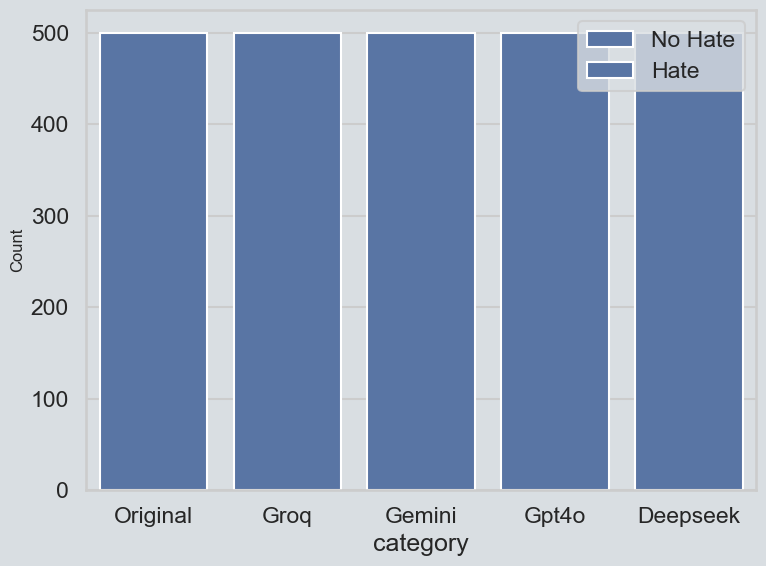

In [14]:
sns.set_palette("deep")
plt.figure(figsize=(8, 6))  
sns.countplot(data=df_long, x="category", hue="label", dodge=True)
plt.ylabel("Count", fontsize=12)
plt.legend(['No Hate', 'Hate'], loc='upper right', frameon=True)
plt.tight_layout()  
plt.show()

In [15]:
df = df[df['labels'] != "No Abuse"]

In [16]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text.lower())

In [17]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,gpt_transformed,transformed_tweets_deepseek,deepseek_transformed,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,Religion,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",1,"""If you take the time to analyze the data, it ...",1,1,1,1,1,1
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,Religion,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",1,"""Some Muslims believe the Quran is true becaus...",1,1,1,1,1,1
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,Religion,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",1,"""Jim Carrey's painting of Sharia Huckabee is a...",1,1,1,1,1,1
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,Religion,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",1,"""I believe Islam should not be practiced in th...",1,1,1,1,1,1
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,Religion,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",1,"""Theresa May seems to be very supportive of th...",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,b'Why does this Globalist Pope meddle in suppo...,globalist pope meddle supporting muslim invasi...,why does this globalist pope meddle in support...,Disciminatory,19,"""I'm concerned about the Pope's influence on g...",1,I question the Pope's focus on supporting Musl...,1,"""Why does this globalist Pope focus on support...",1,"""Why does the Pope focus on supporting Muslim ...",1,1,1,1,1,1
396,b'RT @BeckysTidePods: FLASHBACK: for the selec...,flashback selective memory whining hypocrite b...,flashback for the selective memory whining hyp...,Disciminatory,19,"""Remembering the contrast between past actions...",1,"Reflecting on past events, it's worth remember...",1,"""Flashback for those with selective memory: Th...",1,"""Here's a reminder for those who might have fo...",1,1,1,1,1,1
397,b'RT @chriscol22nd: Illinois: Two Muslims indi...,illinois two muslim indicted spying behalf ira...,illinois two muslims indicted for spying on be...,Disciminatory,19,"""Breaking: Two individuals in Illinois have be...",1,Two individuals in Illinois have been indicted...,1,"""Two individuals in Illinois have been indicte...",1,"""Two individuals from Illinois have been indic...",1,1,1,1,1,1
398,b'@najwazebian Wishing all young Lebanese fema...,wishing young lebanese female teacher living l...,wishing all young lebanese female teachers liv...,Disciminatory,19,"""Wishing all young Lebanese female teachers li...",1,Wishing all young Lebanese female teachers in ...,1,"""Wishing all young Lebanese female teachers li...",1,"""Wishing all young Lebanese female teachers li...",1,1,1,1,1,1


In [18]:
# function that checks whether or not the keyword is in the text
def search_keywords(tweet):
    for keyword in keywords:
        if re.search(rf'\b{re.escape(keyword)}\b', str(tweet), re.IGNORECASE):
            return 1
    return 0

def clean_transformation(model):
    no_punct = df[f'transformed_tweets_{model}'].apply(lambda x: remove_punctuation(x))
    df[f"hate_keyword_{model}"] = no_punct.apply(lambda x: search_keywords(x))
    

models = ['groq', 'gemini', 'gpt', 'deepseek']    
df['hate_keyword_before'] = df['cleaned_transform'].apply(lambda x: search_keywords(x))
for model in models:
    clean_transformation(model)




In [19]:
df['hate_keyword_before'].value_counts()

hate_keyword_before
0    343
1     57
Name: count, dtype: int64

In [20]:
df['hate_keyword_groq'].value_counts()

hate_keyword_groq
0    396
1      4
Name: count, dtype: int64

In [21]:
df['hate_keyword_gemini'].value_counts()

hate_keyword_gemini
0    394
1      6
Name: count, dtype: int64

In [22]:
df['hate_keyword_gpt'].value_counts()

hate_keyword_gpt
0    397
1      3
Name: count, dtype: int64

In [23]:
df['hate_keyword_deepseek'].value_counts()

hate_keyword_deepseek
0    397
1      3
Name: count, dtype: int64

In [24]:
keyword_df = df[['hate_keyword_before', 'hate_keyword_groq', 'hate_keyword_gemini', 'hate_keyword_gpt', 'hate_keyword_deepseek']]
keyword_df = keyword_df.rename(columns={"hate_keyword_before": "Original", "hate_keyword_groq": "Groq", "hate_keyword_gemini": "Gemini", "hate_keyword_gpt": "GPT-4o", "hate_keyword_deepseek": "DeepSeek"})

In [25]:
keyword_long = keyword_df.melt(var_name="category", value_name="label")

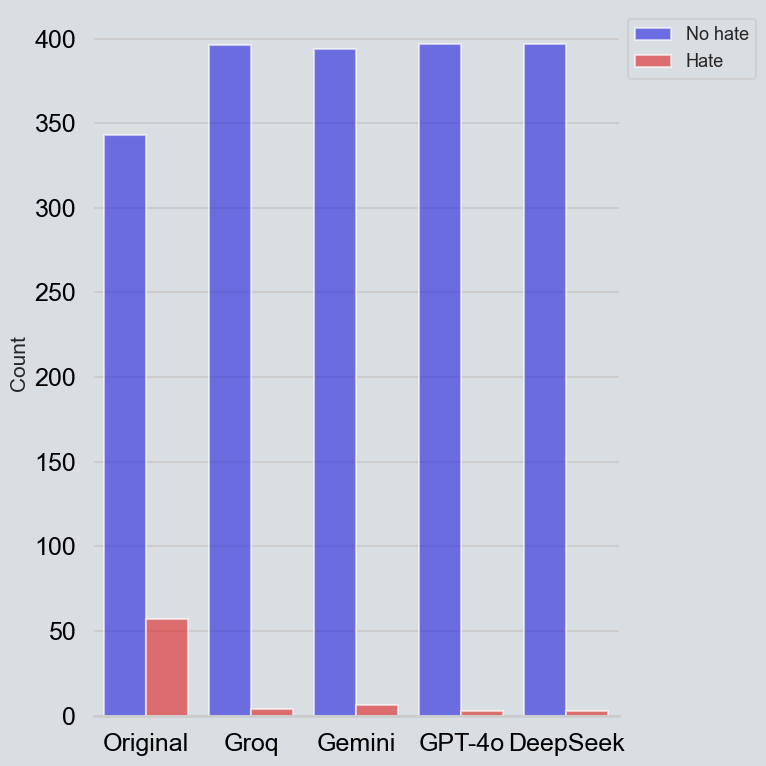

In [26]:
cols = ["blue", "red"]
plt.figure(figsize=(8, 8))  

ax = sns.countplot(data=keyword_long, x="category", hue="label", palette=cols, dodge=True, alpha=.6)
sns.despine(left=True)

plt.xlabel("", fontsize=15)
plt.ylabel("Count", fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(labelcolor="black", labelsize="medium", width=0)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['No hate', 'Hate'], loc='upper left', bbox_to_anchor=(1, 1), frameon=True, fontsize=13)

plt.tight_layout()
plt.show()

In [27]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,...,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek,hate_keyword_before,hate_keyword_groq,hate_keyword_gemini,hate_keyword_gpt,hate_keyword_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,Religion,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",...,1,1,1,1,1,0,0,0,0,0
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,Religion,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",...,1,1,1,1,1,0,0,0,0,0
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,Religion,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",...,1,1,1,1,1,0,0,0,0,0
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,Religion,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",...,1,1,1,1,1,0,0,0,0,0
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,Religion,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",...,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,b'Why does this Globalist Pope meddle in suppo...,globalist pope meddle supporting muslim invasi...,why does this globalist pope meddle in support...,Disciminatory,19,"""I'm concerned about the Pope's influence on g...",1,I question the Pope's focus on supporting Musl...,1,"""Why does this globalist Pope focus on support...",...,1,1,1,1,1,0,0,0,0,0
396,b'RT @BeckysTidePods: FLASHBACK: for the selec...,flashback selective memory whining hypocrite b...,flashback for the selective memory whining hyp...,Disciminatory,19,"""Remembering the contrast between past actions...",1,"Reflecting on past events, it's worth remember...",1,"""Flashback for those with selective memory: Th...",...,1,1,1,1,1,0,0,0,0,0
397,b'RT @chriscol22nd: Illinois: Two Muslims indi...,illinois two muslim indicted spying behalf ira...,illinois two muslims indicted for spying on be...,Disciminatory,19,"""Breaking: Two individuals in Illinois have be...",1,Two individuals in Illinois have been indicted...,1,"""Two individuals in Illinois have been indicte...",...,1,1,1,1,1,0,0,0,0,0
398,b'@najwazebian Wishing all young Lebanese fema...,wishing young lebanese female teacher living l...,wishing all young lebanese female teachers liv...,Disciminatory,19,"""Wishing all young Lebanese female teachers li...",1,Wishing all young Lebanese female teachers in ...,1,"""Wishing all young Lebanese female teachers li...",...,1,1,1,1,1,0,0,0,0,0


In [28]:
keyword_df['labels'] = df['labels']

In [29]:
keyword_df

,Original,Groq,Gemini,GPT-4o,DeepSeek,labels
0,0,0,0,0,0,Religion
1,0,0,0,0,0,Religion
2,0,0,0,0,0,Religion
3,0,0,0,0,0,Religion
4,0,0,0,0,0,Religion
...,...,...,...,...,...,...
395,0,0,0,0,0,Disciminatory
396,0,0,0,0,0,Disciminatory
397,0,0,0,0,0,Disciminatory
398,0,0,0,0,0,Disciminatory


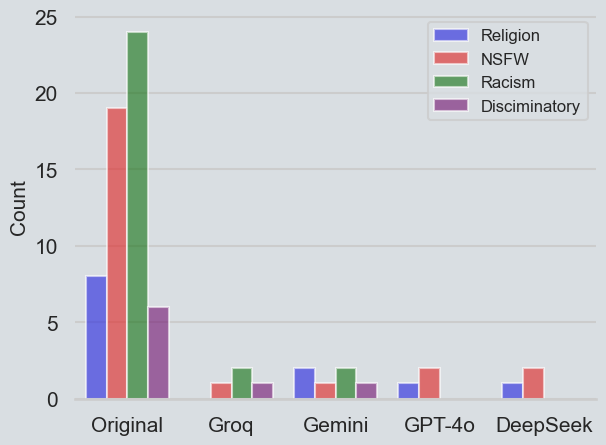

In [ ]:
melted_df = keyword_df.melt(id_vars=['labels'], value_vars=['Original', 'Groq', 'Gemini', 'GPT-4o', 'DeepSeek'], 
                            var_name='Category', value_name='value')
melted_df = melted_df[melted_df['value'] > 0]

cols = ["blue", "red", "green", "purple"]
sns.countplot(data=melted_df, x='Category', hue='labels', palette=cols, alpha=0.6)
sns.despine(left=True)
plt.xlabel("", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.ylabel("Count", fontsize=15)
plt.tight_layout()  

## Ngrams

In [31]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,...,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek,hate_keyword_before,hate_keyword_groq,hate_keyword_gemini,hate_keyword_gpt,hate_keyword_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,Religion,0,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",...,1,1,1,1,1,0,0,0,0,0
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,Religion,0,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",...,1,1,1,1,1,0,0,0,0,0
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,Religion,0,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",...,1,1,1,1,1,0,0,0,0,0
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,Religion,0,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",...,1,1,1,1,1,0,0,0,0,0
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,Religion,0,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",...,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,b'Why does this Globalist Pope meddle in suppo...,globalist pope meddle supporting muslim invasi...,why does this globalist pope meddle in support...,Disciminatory,19,"""I'm concerned about the Pope's influence on g...",1,I question the Pope's focus on supporting Musl...,1,"""Why does this globalist Pope focus on support...",...,1,1,1,1,1,0,0,0,0,0
396,b'RT @BeckysTidePods: FLASHBACK: for the selec...,flashback selective memory whining hypocrite b...,flashback for the selective memory whining hyp...,Disciminatory,19,"""Remembering the contrast between past actions...",1,"Reflecting on past events, it's worth remember...",1,"""Flashback for those with selective memory: Th...",...,1,1,1,1,1,0,0,0,0,0
397,b'RT @chriscol22nd: Illinois: Two Muslims indi...,illinois two muslim indicted spying behalf ira...,illinois two muslims indicted for spying on be...,Disciminatory,19,"""Breaking: Two individuals in Illinois have be...",1,Two individuals in Illinois have been indicted...,1,"""Two individuals in Illinois have been indicte...",...,1,1,1,1,1,0,0,0,0,0
398,b'@najwazebian Wishing all young Lebanese fema...,wishing young lebanese female teacher living l...,wishing all young lebanese female teachers liv...,Disciminatory,19,"""Wishing all young Lebanese female teachers li...",1,Wishing all young Lebanese female teachers in ...,1,"""Wishing all young Lebanese female teachers li...",...,1,1,1,1,1,0,0,0,0,0


In [32]:
def censor_words(text): # censoring words
    word_censor = {"nigga": "n*gga", "nigger": "n*gger",  "anal": "@n@l", "booty": "b**ty", "pussy": "p*ssy", "sex": "s*x"}
    for word in word_censor:
        text = text.replace(word, word_censor[word])
    return text
    

In [33]:
def clean_llm_text(text): # lower lemmatize and return censored words
    stopwords_set = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r"-", " ", text) 
    text = re.sub(r"[^\w\s]", "", text)  
    tokens = word_tokenize(text)  
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_set]
    text = " ".join(filtered_tokens)  
    text = censor_words(text)  
    
    return text  

In [34]:
def clean_and_make_ngram(model, n): # function to make ngram
    column = f'transformed_tweets_{model}'
    if model == "cleaned":
        column = "cleaned"
    after = df[column].astype(str).apply(clean_llm_text)  
    after_tokens = after.apply(lambda text: text.split()) 
    after_ngrams = after_tokens.apply(lambda tokens: list(ngrams(tokens, n)))
    after_ngrams = [ngram for ngram_list in after_ngrams for ngram in ngram_list]
    counts = Counter(after_ngrams)
    top_10_ngrams = counts.most_common(10)
    return top_10_ngrams

In [35]:
def ngram_to_df(ngram_list, model, n):
    return pd.DataFrame({
        "Model": model,
        "N": n,
        "N-gram": [" ".join(ngram) for ngram, _ in ngram_list],
        "Count": [freq for _, freq in ngram_list]
    })

In [36]:
df_bigrams_before = ngram_to_df(clean_and_make_ngram("cleaned", 2), "before", 2)
df_trigrams_before = ngram_to_df(clean_and_make_ngram("cleaned", 3), "before", 3)

df_bigrams_groq = ngram_to_df(clean_and_make_ngram("groq", 2), "groq", 2)
df_trigrams_groq = ngram_to_df(clean_and_make_ngram("groq", 3), "groq", 3)

df_bigrams_gemini = ngram_to_df(clean_and_make_ngram("gemini", 2), "gemini", 2)
df_trigrams_gemini = ngram_to_df(clean_and_make_ngram("gemini", 3), "gemini", 3)

df_bigrams_gpt = ngram_to_df(clean_and_make_ngram("gpt", 2), "gpt", 2)
df_trigrams_gpt = ngram_to_df(clean_and_make_ngram("gpt", 3), "gpt", 3)

df_bigrams_deepseek = ngram_to_df(clean_and_make_ngram("deepseek", 2), "deepseek", 2)
df_trigrams_deepseek = ngram_to_df(clean_and_make_ngram("deepseek", 3), "deepseek", 3)

df_ngrams = pd.concat([
    df_bigrams_before, df_trigrams_before, 
    df_bigrams_groq, df_trigrams_groq, 
    df_bigrams_gemini, df_trigrams_gemini,
    df_bigrams_gpt, df_trigrams_gpt,
    df_bigrams_deepseek, df_trigrams_deepseek
], ignore_index=True)



In [37]:
df_ngrams

,Model,N,N-gram,Count
0,before,2,sharia law,19
1,before,2,link bio,4
2,before,2,bio @n@l,4
3,before,2,people want,3
4,before,2,left want,3
...,...,...,...,...
95,deepseek,3,prophet muhammad pbuh,2
96,deepseek,3,different im used,2
97,deepseek,3,ive asked remove,2
98,deepseek,3,let focus constructive,2


In [38]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}

C:\Users\jiyon\AppData\Local\Temp\ipykernel_4040\4007442564.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


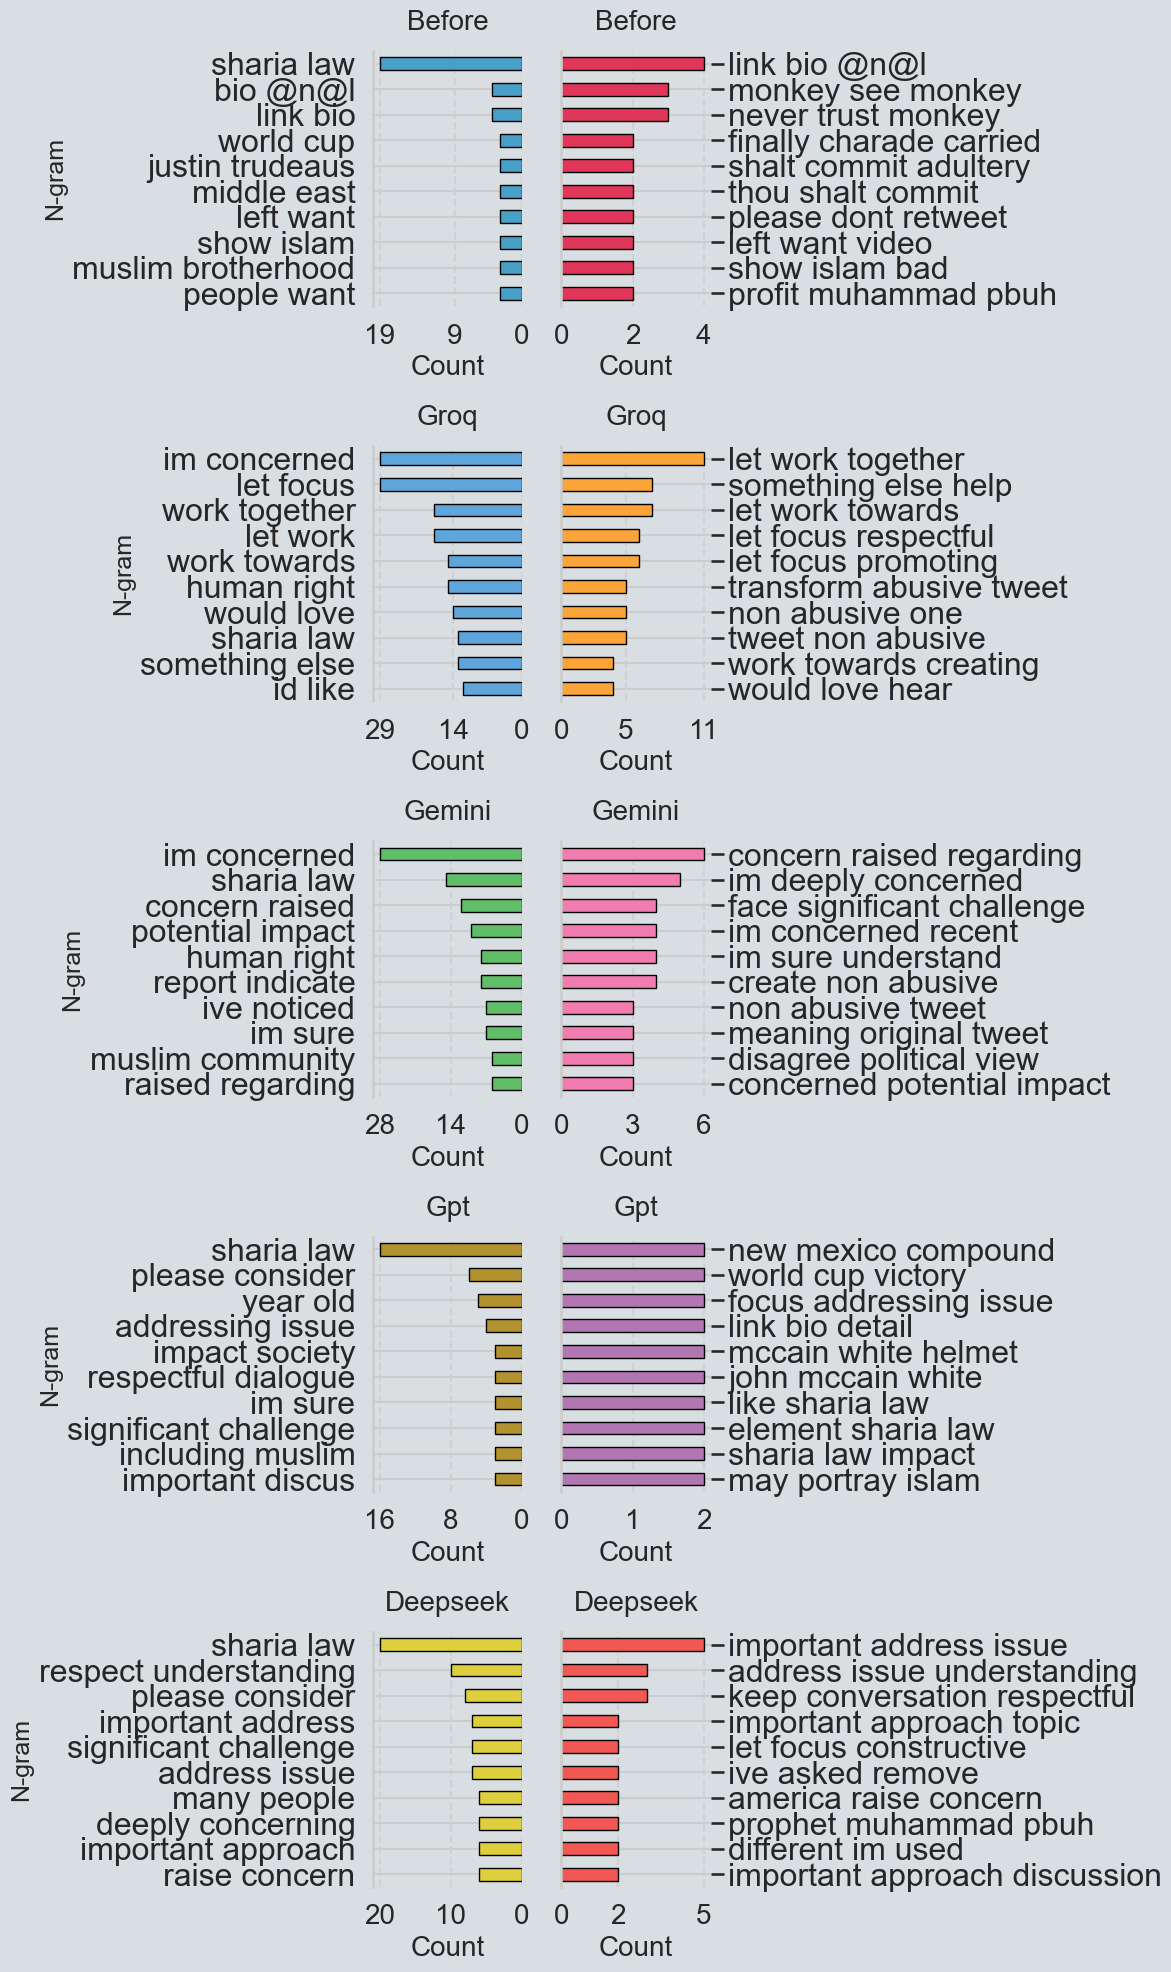

In [39]:
def make_ngram_plot(df_ngrams): # function to make a subplot of before and the two models
    models = ["before", "groq", "gemini", 'gpt', 'deepseek']
    model_colors = {
        "before": [barcolors[3], barcolors[6]],
        "groq":    ['#5DA5DA', '#FAA43A'],  # blue, orange
        "gemini":  ['#60BD68', '#F17CB0'],  # green, pink
        "gpt":     ['#B2912F', '#B276B2'],  # brown, purple
        "deepseek":['#DECF3F', '#F15854']   # yellow, red  
    }
    
    plt.rcParams.update({'font.size': 16})  # Increase font size globally
    
    fig, axes = plt.subplots(5, 2, figsize=(12, 20), constrained_layout=True)  
    
    for i, model in enumerate(models):
        bigram = df_ngrams[(df_ngrams['Model'] == model) & (df_ngrams['N'] == 2)]
        trigram = df_ngrams[(df_ngrams['Model'] == model) & (df_ngrams['N'] == 3)]
        bigram_sorted = bigram.sort_values('Count', ascending=True)
        bigram_sorted.plot.barh(
            x='N-gram', y='Count', ax=axes[i, 0], color=model_colors[model][0], legend=False, **barstyle)
        axes[i, 0].set_xlabel("Count", fontsize=20)
        axes[i, 0].invert_xaxis()
        axes[i, 0].grid(True, axis='x', linestyle='--', alpha=0.7)

        axes[i, 0].tick_params(axis='y', which='major', labelsize=23)
        axes[i, 0].tick_params(axis='x', which='major', labelsize=20)

        axes[i, 0].set_title(f"{model.capitalize()}", fontsize=20, pad=15)


        x_ticks = np.linspace(0, bigram_sorted['Count'].max(), num=3) # set more ticks
        axes[i, 0].set_xticks(x_ticks.astype(int))

        trigram_sorted = trigram.sort_values('Count', ascending=True)
        trigram_sorted.plot.barh(
            x='N-gram', y='Count', ax=axes[i, 1], color=model_colors[model][1], legend=False, **barstyle)
        axes[i, 1].set_xlabel("Count", fontsize=20)
        axes[i, 1].yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
        axes[i, 1].set_ylabel("")
        axes[i, 1].grid(True, axis='x', linestyle='--', alpha=0.7)
        axes[i, 1].tick_params(axis='y', which='major', labelsize=23)
        axes[i, 1].tick_params(axis='x', which='major', labelsize=20)

        axes[i, 1].set_title(f"{model.capitalize()}", fontsize=20, pad=15)

        x_ticks = np.linspace(0, trigram_sorted['Count'].max(), num=3) # more ticks
        axes[i, 1].set_xticks(x_ticks.astype(int))

        sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()

make_ngram_plot(df_ngrams)

# Transformation rate visualizations and analysis


In [40]:
df['batch'] = df['batch'] + 1 # batch started with 0 so add 1

In [41]:
df_batch_mean = df.groupby("batch").agg(
    Groq=("groq_transformed", "mean"),
    Gemini=("gemini_transformed", "mean"),
    GPT=("gpt_transformed", "mean"),
    DeepSeek=("deepseek_transformed", "mean")
).reset_index()

df_long = df_batch_mean.melt(id_vars="batch", var_name="Model", value_name="Successful Transformations") # get into right format
df_long

,batch,Model,Successful Transformations
0,1,Groq,0.95
1,2,Groq,0.90
2,3,Groq,0.95
3,4,Groq,1.00
4,5,Groq,0.95
...,...,...,...
75,16,DeepSeek,1.00
76,17,DeepSeek,0.95
77,18,DeepSeek,0.95
78,19,DeepSeek,1.00


In [42]:
df_batch_sum = df.groupby("batch").agg(
    Groq=("groq_transformed", "sum"),
    Gemini=("gemini_transformed", "sum"),
    GPT=("gpt_transformed", "sum"),
    DeepSeek=("deepseek_transformed", "sum")
    
).reset_index()

In [43]:
df_batch_sum.to_csv("../../Dataset/tweets/results/sum_summary.csv", index=False)

In [44]:
df_label_sum = df.groupby("labels").agg(
    Groq=("groq_transformed", "sum"),
    Gemini=("gemini_transformed", "sum"),
        GPT=("gpt_transformed", "sum"),
    DeepSeek=("deepseek_transformed", "sum")
).reset_index()
df_label_sum

,labels,Groq,Gemini,GPT,DeepSeek
0,Disciminatory,95,95,98,98
1,NSFW,94,96,100,100
2,Racism,87,96,99,97
3,Religion,95,98,99,98


In [45]:
melted_df_label_sum = df_label_sum.melt(id_vars='labels', var_name='Model', value_name='Transformed')

In [46]:
melted_df_label_sum

,labels,Model,Transformed
0,Disciminatory,Groq,95
1,NSFW,Groq,94
2,Racism,Groq,87
3,Religion,Groq,95
4,Disciminatory,Gemini,95
5,NSFW,Gemini,96
6,Racism,Gemini,96
7,Religion,Gemini,98
8,Disciminatory,GPT,98
9,NSFW,GPT,100


Text(0.5, 1.0, 'Successful transformation counts by Model and Abuse type')

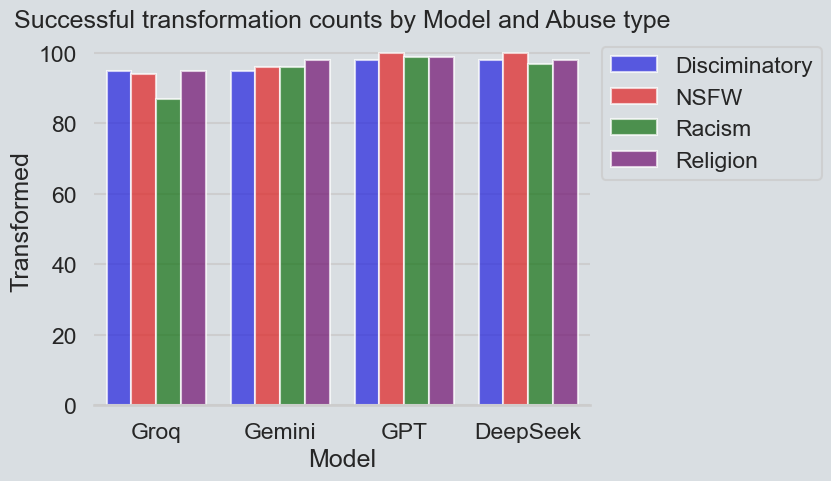

In [47]:

ax = sns.barplot(data=melted_df_label_sum, x='Model', y='Transformed', hue='labels', palette=cols, alpha=0.7)
sns.despine(left=True)
ax.grid(axis='y', linestyle='-', alpha=0.9)  
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Successful transformation counts by Model and Abuse type")


In [48]:
df_batch_mean.to_csv("../../Dataset/tweets/results/mean_summary.csv", index=False)

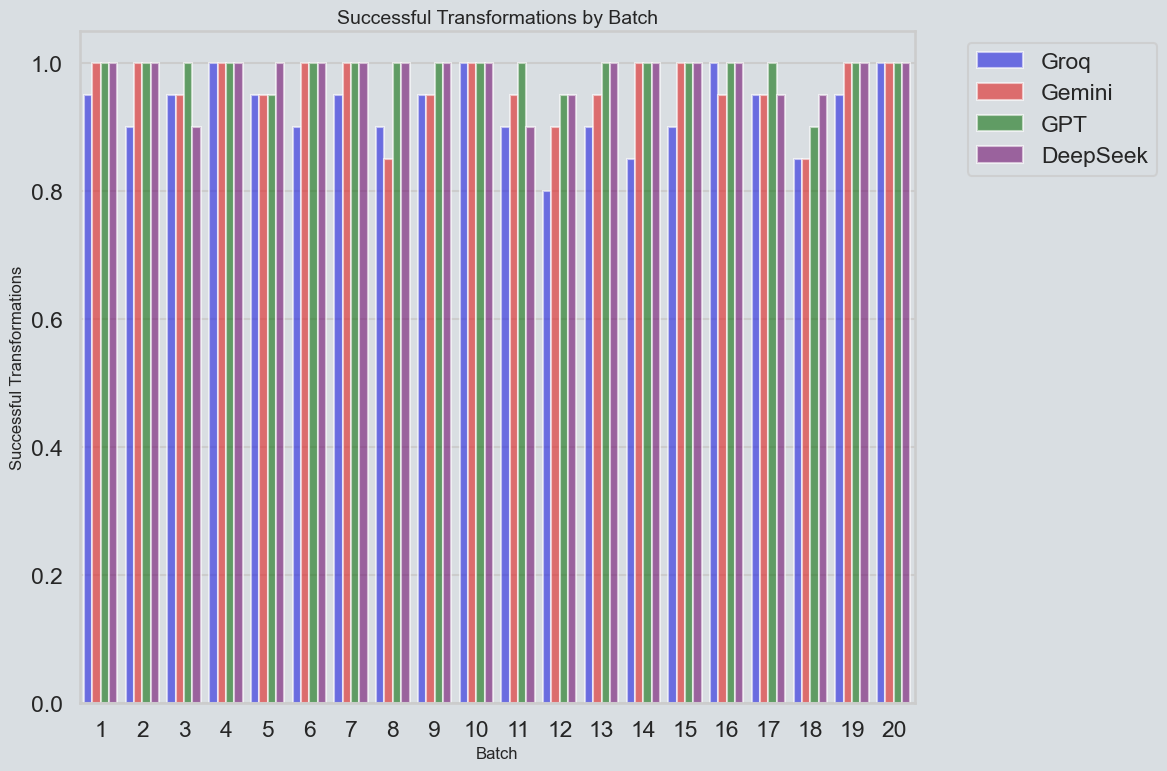

In [49]:

plt.figure(figsize=(12, 8))
sns.barplot(data=df_long, x="batch", y="Successful Transformations", hue="Model", palette=cols, alpha=0.6)

plt.title("Successful Transformations by Batch", fontsize=14)
plt.xlabel("Batch", fontsize=12)
plt.ylabel("Successful Transformations", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)

plt.tight_layout() 
plt.show()

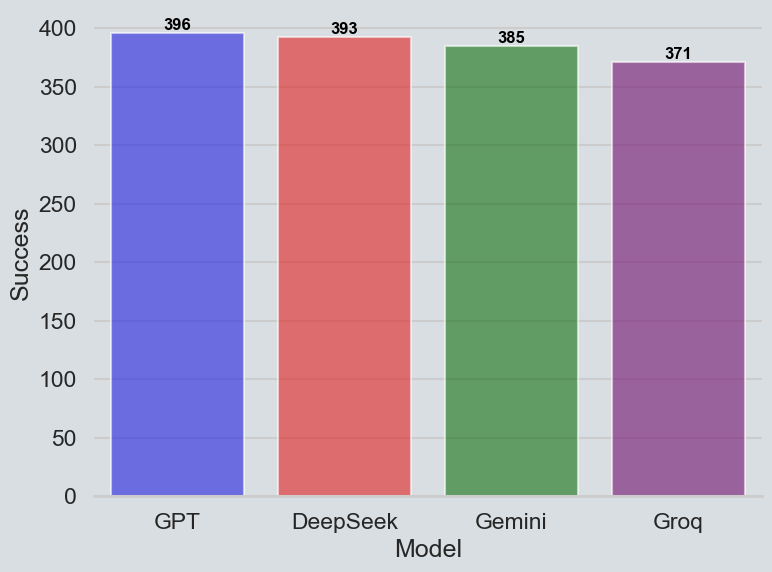

In [50]:
success = melted_df_label_sum.groupby("Model").agg(Success=('Transformed', 'sum'))
success.sort_values("Success", ascending=False, inplace=True)
plt.figure(figsize=(8,6))
ax = sns.barplot(success, x="Model", y="Success", hue="Model", palette=cols, alpha=0.6)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",  # height as string
                (p.get_x() + p.get_width() / 2, p.get_height()),  # center top
                ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")  # style
sns.despine(left=True)
plt.tight_layout()

In [51]:
random_rows = df.groupby("labels").sample(random_state=42)

In [52]:
random_rows # this is for the table in the overleaf document

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,...,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek,hate_keyword_before,hate_keyword_groq,hate_keyword_gemini,hate_keyword_gpt,hate_keyword_deepseek
383,b'All the people with the Palestine Terrorism ...,people palestine terrorism flag profile today ...,all the people with the palestine terrorism fl...,Disciminatory,20,"""I'm curious to understand why so many people ...",1,I've noticed many profiles displaying the Pale...,1,"""All the people with the Palestinian flag in t...",...,1,1,1,1,1,0,0,0,0,0
179,b'The people who want Boris Johnson destroyed ...,people want boris johnson destroyed accurately...,the people who want boris johnson destroyed fo...,NSFW,9,"""I'm disappointed to see some people are calli...",1,Some disagree with Boris Johnson's description...,1,"""The people who want Boris Johnson criticized ...",...,1,1,1,1,1,0,0,0,0,0
248,"b""Also, why aren't all the other fake refugees...",also arent fake refugee balkan africa even rem...,also why arent all the other fake refugees fro...,Racism,13,"""Why aren't we also acknowledging the struggle...",1,I'm curious why individuals from various backg...,1,"""Also, why haven't other refugees from the Bal...",...,1,1,1,1,1,0,0,0,0,0
98,"b""The #sinkhole isn't from Me. It's from Satan...",sinkhole isnt satan way telling trump contract...,the sinkhole isnt from me its from satan its h...,Religion,5,"""I'm unclear about the cause of the recent sin...",1,I think the sinkhole is unrelated to me; perha...,1,"""The sinkhole isn't caused by me; perhaps it's...",...,1,1,1,1,1,0,0,0,0,0


In [53]:
# save rows with columns we want
random_rows[['cleaned_transform', 'transformed_tweets_groq', 'transformed_tweets_gemini', 'transformed_tweets_gpt', 'transformed_tweets_deepseek', 'labels']].rename(columns={"cleaned_transform": "Original", "transformed_tweets_groq": "Groq", "transformed_tweets_gemini": "Gemini", "transformed_tweets_gpt": "Gpt-4o", "transformed_tweets_deepseek": "DeepSeek"}).to_csv("../../Plots/transformation_table.csv")

In [54]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,...,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek,hate_keyword_before,hate_keyword_groq,hate_keyword_gemini,hate_keyword_gpt,hate_keyword_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,Religion,1,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",...,1,1,1,1,1,0,0,0,0,0
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,Religion,1,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",...,1,1,1,1,1,0,0,0,0,0
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,Religion,1,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",...,1,1,1,1,1,0,0,0,0,0
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,Religion,1,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",...,1,1,1,1,1,0,0,0,0,0
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,Religion,1,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",...,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,b'Why does this Globalist Pope meddle in suppo...,globalist pope meddle supporting muslim invasi...,why does this globalist pope meddle in support...,Disciminatory,20,"""I'm concerned about the Pope's influence on g...",1,I question the Pope's focus on supporting Musl...,1,"""Why does this globalist Pope focus on support...",...,1,1,1,1,1,0,0,0,0,0
396,b'RT @BeckysTidePods: FLASHBACK: for the selec...,flashback selective memory whining hypocrite b...,flashback for the selective memory whining hyp...,Disciminatory,20,"""Remembering the contrast between past actions...",1,"Reflecting on past events, it's worth remember...",1,"""Flashback for those with selective memory: Th...",...,1,1,1,1,1,0,0,0,0,0
397,b'RT @chriscol22nd: Illinois: Two Muslims indi...,illinois two muslim indicted spying behalf ira...,illinois two muslims indicted for spying on be...,Disciminatory,20,"""Breaking: Two individuals in Illinois have be...",1,Two individuals in Illinois have been indicted...,1,"""Two individuals in Illinois have been indicte...",...,1,1,1,1,1,0,0,0,0,0
398,b'@najwazebian Wishing all young Lebanese fema...,wishing young lebanese female teacher living l...,wishing all young lebanese female teachers liv...,Disciminatory,20,"""Wishing all young Lebanese female teachers li...",1,Wishing all young Lebanese female teachers in ...,1,"""Wishing all young Lebanese female teachers li...",...,1,1,1,1,1,0,0,0,0,0


In [55]:
df_batch_mean = df.groupby("batch").agg(
    Groq=("groq_transformed", "mean"),
    Gemini=("gemini_transformed", "mean")
).reset_index()

In [56]:
line_data = df.groupby("batch").agg(Before=('hate_keyword_before', 'sum'), Groq=('hate_keyword_groq', 'sum'), Gemini=('hate_keyword_gemini', 'sum'),GPT=("hate_keyword_gpt", "sum"),
    DeepSeek=("hate_keyword_deepseek", "sum")).reset_index()
line_melted = line_data.melt(id_vars="batch", var_name="Model", value_name="Hate")

In [57]:
line_melted

,batch,Model,Hate
0,1,Before,2
1,2,Before,0
2,3,Before,2
3,4,Before,2
4,5,Before,2
...,...,...,...
95,16,DeepSeek,0
96,17,DeepSeek,0
97,18,DeepSeek,0
98,19,DeepSeek,0


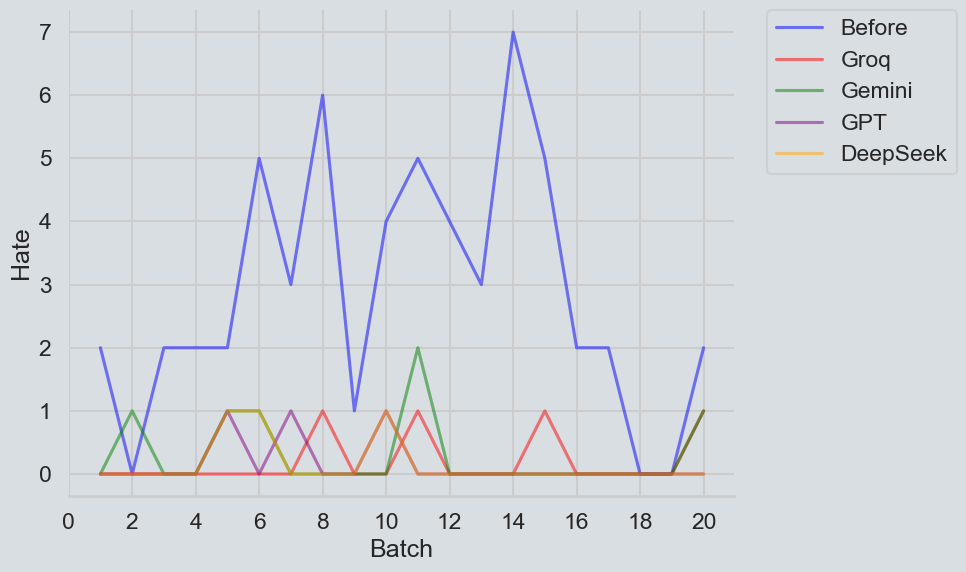

In [58]:
cols = cols + ["orange"]
plt.figure(figsize=(10, 6))
sns.lineplot(data=line_melted, x="batch", y="Hate", hue="Model", palette = cols, alpha=0.5)

plt.xlabel("Batch")

plt.xticks(ticks=np.arange(0, 21, 2))

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

sns.despine(left=True)
plt.tight_layout()
plt.show()


In [59]:
df.to_csv("../../Dataset/tweets/transformed_final.csv", index=False)